This notebook is about analysing Audi's dataset and predicting car prices

I would like to mention these amazing notebooks that walked me through linear regression, feature engineering and data visualization \
[Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)\
[A study on Regression applied to the Ames dataset](https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook)\
[Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard)


In [441]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from scipy.stats import norm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')


In [442]:
df_frame = pd.read_csv('audi.csv')


Lets take a look at the features and study them 


In [443]:
df_frame.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

Lets start with describing the price our (y)


In [444]:
df_frame['price'].describe()

count     10668.000000
mean      22896.685039
std       11714.841888
min        1490.000000
25%       15130.750000
50%       20200.000000
75%       27990.000000
max      145000.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

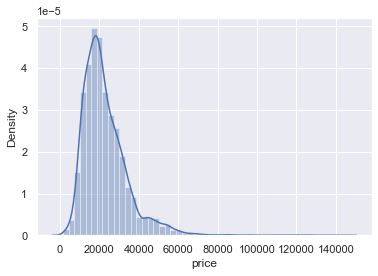

In [445]:
sns.distplot(df_frame.price)

In [446]:
print("Skewness: %f" % df_frame['price'].skew())
print("Kurtosis: %f" % df_frame['price'].kurt())

Skewness: 2.277323
Kurtosis: 11.671632


The model has high skewness and kurtosis so we need make it more of a normal distribution and decrease the skewness and kurtosis

Lets try boxcox algorithm 


In [447]:
box_cox = stats.boxcox(df_frame.price)[0]
df_frame.price = (pd.Series(box_cox))

<AxesSubplot:xlabel='price', ylabel='Density'>

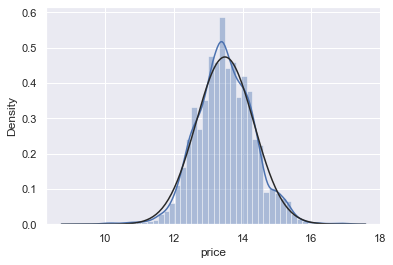

In [448]:
sns.distplot(df_frame.price, fit = norm)

In [449]:
print("Skewness: %f" % df_frame['price'].skew())
print("Kurtosis: %f" % df_frame['price'].kurt())

Skewness: 0.008729
Kurtosis: 0.930494


Amazing! 
Lets move on to other predictors

We can tell that manual has bad prices generaly 
but Auto and semi Auto have the same range


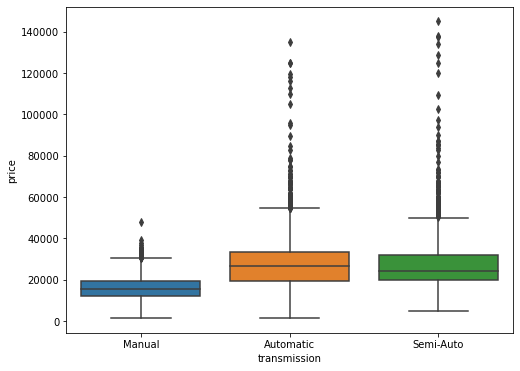

In [55]:
var = 'transmission'
data = pd.concat([df_frame['price'], df_frame[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
#fig.axis(ymin=0, ymax=800000);

Some models have very prices while other have better ranges 


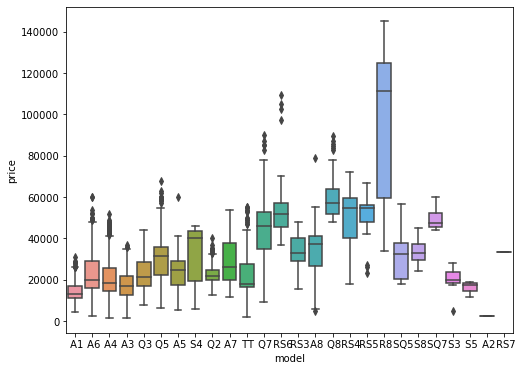

In [54]:
var = 'model'
data = pd.concat([df_frame['price'], df_frame[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
#fig.axis(ymin=0, ymax=800000);

we can see there is a sharp nonlinear relationship between year and price 
This is important cause we will create new feauters to describe this sharp relationship

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


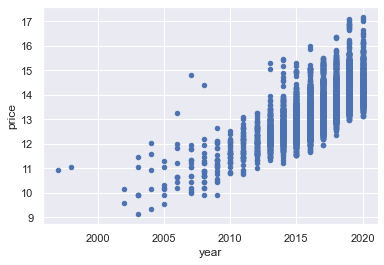

In [450]:
#scatter plot grlivarea/saleprice
var = 'year'
data = pd.concat([df_frame['price'], df_frame[var]], axis=1)
data.plot.scatter(x=var, y='price');

Unfortunatly I cant see a direct relationship although price and engineSize are correlated

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


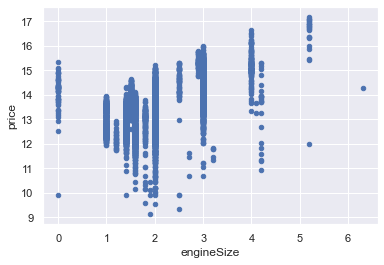

In [451]:
#scatter plot grlivarea/saleprice
var = 'engineSize'
data = pd.concat([df_frame['price'], df_frame[var]], axis=1)
data.plot.scatter(x=var, y='price');

A sharpe inverse relationship is seen between mpg and price 
which makes a lot of sense

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


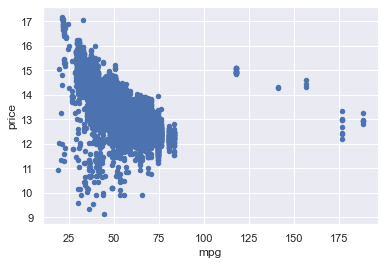

In [452]:
#scatter plot grlivarea/saleprice
var = 'mpg'
data = pd.concat([df_frame['price'], df_frame[var]], axis=1)
data.plot.scatter(x=var, y='price');

This is also sharp inverse could be nonlinear 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


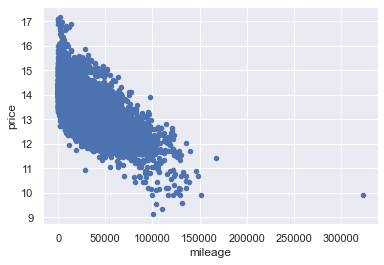

In [382]:
#scatter plot grlivarea/saleprice
var = 'mileage'
data = pd.concat([df_frame['price'], df_frame[var]], axis=1)
data.plot.scatter(x=var, y='price');

Now lets find which parameters are important and which are not 

In [380]:
corrmat = df_frame.corr()
corr = corrmat.sort_values(['price'], ascending = False)
print("The correlation values with respect to price are:")
print(corr.price.head(10))

The correlation values with respect to price are:
price         1.000000
year          0.741899
engineSize    0.495938
tax           0.410780
mpg          -0.619472
mileage      -0.675062
Name: price, dtype: float64


We can see that year, mileage and mpg are important 
and also engineSize but to a lesser degree

Now lets see which variables are colinear 
My favorite way is heatmap 

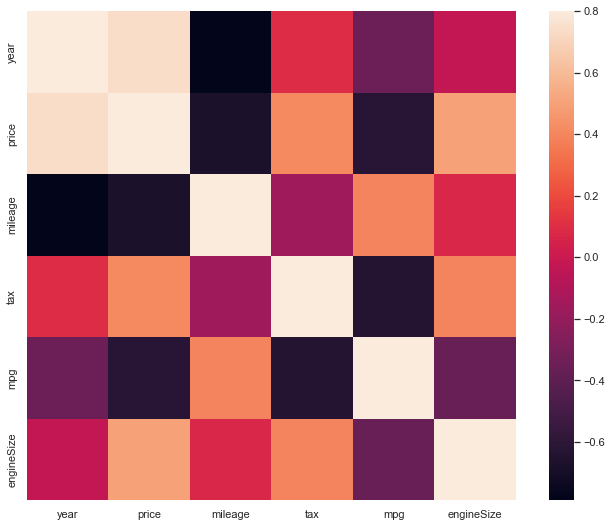

In [383]:
#correlation matrix
corrmat = df_frame.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

From this heatmap we can see strong collinearity between mileage and year
and colinearity between tax and mpg

Finally that we are done analysing lets get to some work! 

# Feature Engineering

Missing Data

In [384]:
df_frame.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Damn! That was easy 
Lets move on to creating new parameters

I created new parameters based on colinearity and nonlinear relationship

In [385]:
df_frame['mileage_year'] = df_frame['year']*df_frame['mileage']
df_frame['tax_mpg'] = df_frame.mpg * df_frame.tax

In [391]:
df_frame['year_squared'] = df_frame.year^2
df_frame['year_cubed'] = df_frame.year^3
df_frame['year_root'] = np.sqrt(df_frame.year)
df_frame['mileage_squared'] = df_frame.mileage^2
df_frame['mileage_root'] = np.sqrt(df_frame.mileage)


Lets check the correlation matrix now

In [392]:
corrmat = df_frame.corr()
corr = corrmat.sort_values(['price'], ascending = False)
print("The correlation values with respect to price are:")
print(corr.price.head)

The correlation values with respect to price are:
<bound method NDFrame.head of price              1.000000
year               0.741899
year_root          0.741832
engineSize         0.495938
year_squared       0.436038
tax                0.410780
year_cubed         0.351330
tax_mpg            0.237787
mpg               -0.619472
mileage_year      -0.674828
mileage_squared   -0.675060
mileage           -0.675062
mileage_root      -0.692491
Name: price, dtype: float64>


Obviously we can see much more correlation 

Now time for OUTLIERS


In [453]:
saleprice_scaled = StandardScaler().fit_transform(df_frame['price'][:,np.newaxis])


In [419]:
low_range = saleprice_scaled[( 3 + saleprice_scaled) <0]
print(f"Number of outliers is {len(low_range)}")
print(f"The biggest outliers are {np.sort(low_range)[:10]}")


Number of outliers is 52
The biggest outliers are [-5.17812974 -4.93800504 -4.66035188 -4.64633094 -4.22812678 -4.22812678
 -4.22812678 -4.22435915 -4.22435915 -4.22435915]


In [420]:
high_range = saleprice_scaled[(saleprice_scaled - 3) >0]
print(f"Number of outliers is {len(high_range)}")
print(f"The biggest outliers are {np.sort(high_range)[:10]}")


Number of outliers is 33
The biggest outliers are [3.08204287 3.08385048 3.1114932  3.12522593 3.13869194 3.13893659
 3.16330601 3.19246775 3.19260073 3.26479792]


In [422]:
print(f"In total we have {len(high_range) + len(low_range)} outliers")

In total we have 85 outliers


I will not delete them since they might be important to the model but I might come back and delete them depending on the model

Now lets transform all the skewed numerical features 

Because we are doing a linear regression model all variables should look something like normally distributed

The numerical features are: mileage, mpg

we will consider mpg as numerical although there is only about 100 unique values because there is floating point values


In [423]:
df_frame.mpg = np.log1p(df_frame.mpg)

In [424]:
mileage = df_frame.mileage
mileage = stats.boxcox(mileage)[0]
df_frame.mileage = pd.Series(mileage)

Our Categorical variables are in string type value 
We need to change them into integer type vales

In [425]:
df_frame.transmission.replace({"Automatic": 1,
                              "Manual": 2, 
                              "Semi-Auto": 3}, inplace = True)
df_frame.fuelType.replace({"Diesel": 1,
                              "Hybrid": 2, 
                              "Petrol": 3}, inplace = True)
uniq_len = len(df_frame.model)

model_dict = {}
count = 1
for i in range(uniq_len):
    if df_frame.model.loc[i] in model_dict.keys():
        df_frame.model.loc[i] = model_dict[df_frame.model.loc[i]]
    else:
        model_dict[df_frame.model.loc[i]] = count
        df_frame.model.loc[i] = count
        count +=1

C:\Users\pc\AppData\Local\Temp\ipykernel_14472\380995449.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frame.model.loc[i] = count
C:\Users\pc\AppData\Local\Temp\ipykernel_14472\380995449.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frame.model.loc[i] = model_dict[df_frame.model.loc[i]]


Lets partition the data now

In [426]:
X_train, X_test, y_train, y_test = train_test_split(df_frame, df_frame.price, test_size = 0.3, random_state = 0)

Now lets standardize the numerical data

I read in other notebooks that standardizing should come after partitioning but I dont know the reason why 

In [428]:
X_train.mileage = StandardScaler().fit_transform(X_train.mileage[:,np.newaxis])
X_train.mpg = StandardScaler().fit_transform(X_train.mpg[:,np.newaxis])
X_train.year_squared = StandardScaler().fit_transform(X_train.year_squared[:,np.newaxis])
X_train.year_cubed = StandardScaler().fit_transform(X_train.year_cubed[:,np.newaxis])
X_train.year_root = StandardScaler().fit_transform(X_train.year_root[:,np.newaxis])
X_train.mileage_squared = StandardScaler().fit_transform(X_train.mileage_squared[:,np.newaxis])
X_train.mileage_year = StandardScaler().fit_transform(X_train.mileage_year[:,np.newaxis])
X_train.tax_mpg = StandardScaler().fit_transform(X_train.tax_mpg[:,np.newaxis])

X_test.mileage = StandardScaler().fit_transform(X_test.mileage[:,np.newaxis])
X_test.mpg = StandardScaler().fit_transform(X_test.mpg[:,np.newaxis])
X_test.year_squared = StandardScaler().fit_transform(X_test.year_squared[:,np.newaxis])
X_test.year_cubed = StandardScaler().fit_transform(X_test.year_cubed[:,np.newaxis])
X_test.year_root = StandardScaler().fit_transform(X_test.year_root[:,np.newaxis])
X_test.mileage_squared = StandardScaler().fit_transform(X_test.mileage_squared[:,np.newaxis])
X_test.mileage_root = StandardScaler().fit_transform(X_test.mileage_root[:,np.newaxis])
X_test.mileage_year = StandardScaler().fit_transform(X_test.mileage_year[:,np.newaxis])
X_test.tax_mpg = StandardScaler().fit_transform(X_test.tax_mpg[:,np.newaxis])




C:\Users\pc\AppData\Local\Temp\ipykernel_14472\2683629996.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_train.mileage = StandardScaler().fit_transform(X_train.mileage[:,np.newaxis])
C:\Users\pc\AppData\Local\Temp\ipykernel_14472\2683629996.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_train.mpg = StandardScaler().fit_transform(X_train.mpg[:,np.newaxis])
C:\Users\pc\AppData\Local\Temp\ipykernel_14472\2683629996.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_train.year_squared = StandardScaler().fit_transform(X_train.year_squared[:,np.newaxis])
C:\Users\pc\Ap

In [429]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

Lets run our model without regularization 

RMSE on Training set : 8.37255273327492e-15
RMSE on Test set : 1.6438151771703432e-14
R2 score on Test set is 1.0


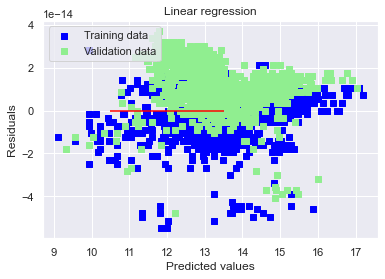

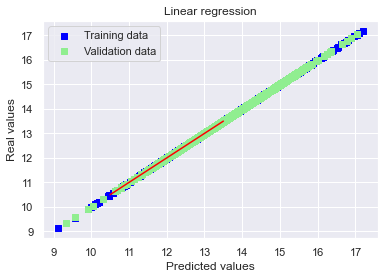

In [435]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
print(f"R2 score on Test set is {r2_score(y_test,y_predict)}")
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Wow! This is weird but its cool 
There is no variation explained by independent error which is worrying but whatever

In [440]:
y_predictions = pd.Series(y_predict)
y_test.reset_index(drop = True, inplace = True)
prediction_table = pd.concat([y_test, y_predictions], axis = 1, keys = ['actual_price', 'prediction'])
#prediction_table.rename()
#prediction_table.sort_values(by = prediction_table.index, ascending = False)
prediction_table.head(100)
#prediction_table.isnull().sum()

,actual_price,prediction
0,12.920338,12.920338
1,13.597527,13.597527
2,14.101818,14.101818
3,13.867480,13.867480
4,14.221616,14.221616
...,...,...
95,11.996422,11.996422
96,13.600800,13.600800
97,13.126395,13.126395
98,13.033715,13.033715
